In [1]:
from xcube.io import open_from_obs
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
from dask.distributed import Client, progress
import graphviz
%matplotlib inline
np.warnings.filterwarnings('ignore')

In [2]:
client = Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:64040 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.03 GB


In [4]:
ds = open_from_obs('dcs4cop-obs-01/OLCI-SNS-RAW-CUBE-2.zarr', endpoint_url='http://obs.eu-de.otc.t-systems.com')

In [5]:
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 1000, lon: 2000, time: 216)
Coordinates:
  * lat            (lat) float64 52.5 52.5 52.49 52.49 52.49 52.49 52.48 ...
    lat_bnds       (lat, bnds) float64 dask.array<shape=(1000, 2), chunksize=(1000, 2)>
  * lon            (lon) float64 0.00125 0.00375 0.00625 0.00875 0.01125 ...
    lon_bnds       (lon, bnds) float64 dask.array<shape=(2000, 2), chunksize=(2000, 2)>
  * time           (time) datetime64[ns] 2016-11-24T09:43:16.372487168 ...
    time_bnds      (time, bnds) datetime64[ns] dask.array<shape=(216, 2), chunksize=(1, 2)>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<shape=(216, 1000, 2000), chunksize=(1, 1000, 2000)>
    conc_chl       (time, lat, lon) float64 dask.array<shape=(216, 1000, 2000), chunksize=(1, 1000, 2000)>
    conc_tsm       (time, lat, lon) float64 dask.array<shape=(216, 1000, 2000), chunksize=(1, 1000, 2000)>
    kd489          (time, lat, lon) f

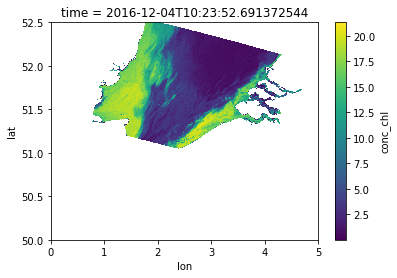

In [6]:
ds.conc_chl.isel(time=9).plot.imshow()

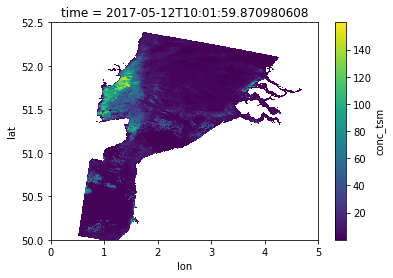

In [7]:
ds.conc_tsm.sel(time=pd.to_datetime('2017-05-12'), method='nearest').plot.imshow()

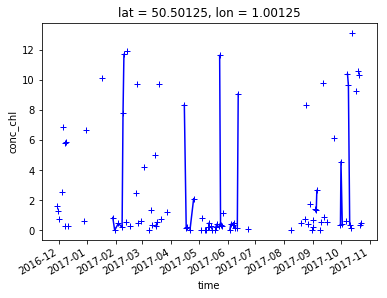

In [8]:
ds.conc_chl.sel(lon=1., lat=50.5, method='nearest').plot.line('b-+')

In [9]:
ds_resampled = ds.resample(time='14d',skipna = True, keep_attrs=True).mean()

In [10]:
ds_resampled

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 1000, lon: 2000, time: 24)
Coordinates:
  * time           (time) datetime64[ns] 2016-11-24T09:43:16.372487168 ...
  * lat            (lat) float64 52.5 52.5 52.49 52.49 52.49 52.49 52.48 ...
    lat_bnds       (lat, bnds) float64 52.5 52.5 52.5 52.5 52.49 52.49 52.49 ...
  * lon            (lon) float64 0.00125 0.00375 0.00625 0.00875 0.01125 ...
    lon_bnds       (lon, bnds) float64 0.0 0.0025 0.0025 0.005 0.005 0.0075 ...
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<shape=(24, 1000, 2000), chunksize=(1, 1000, 2000)>
    conc_chl       (time, lat, lon) float64 dask.array<shape=(24, 1000, 2000), chunksize=(1, 1000, 2000)>
    conc_tsm       (time, lat, lon) float64 dask.array<shape=(24, 1000, 2000), chunksize=(1, 1000, 2000)>
    kd489          (time, lat, lon) float64 dask.array<shape=(24, 1000, 2000), chunksize=(1, 1000, 2000)>
    quality_flags  (time, lat, lon) float6

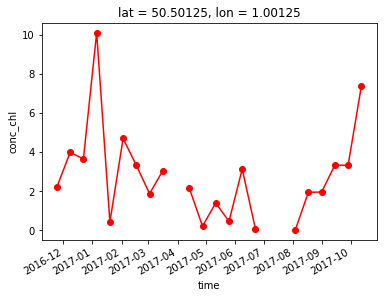

In [11]:
ds_resampled.conc_chl.sel(lon=1., lat=50.5, method='nearest').plot.line('r-o')

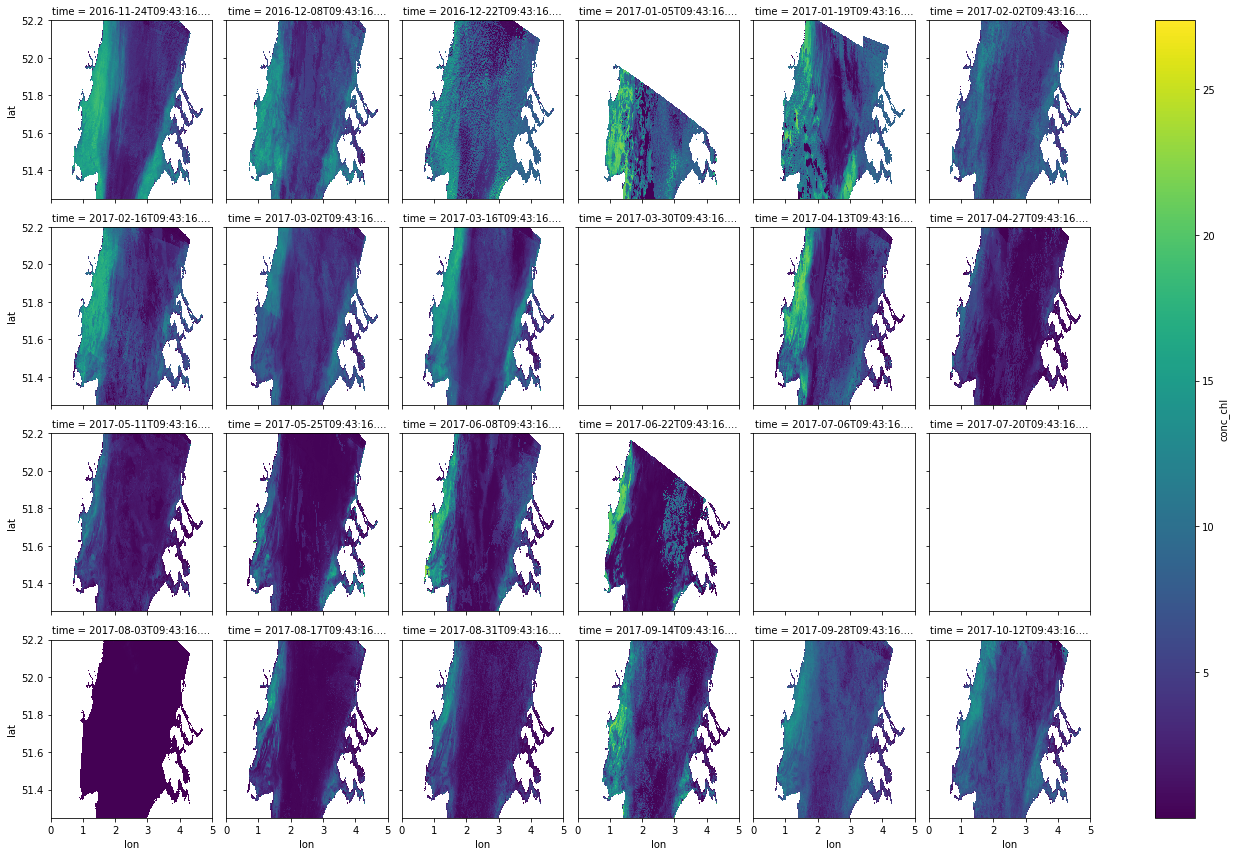

In [12]:
ds_resampled.sel(lat = slice(52.2,51.25)).conc_chl.plot.imshow(x='lon',y='lat',col='time',col_wrap=6)

In [13]:
ds_zscore = (ds-ds.mean(dim='time'))/ds.std(dim='time')

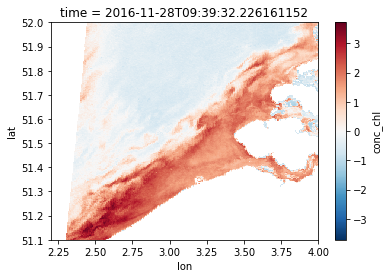

In [14]:
ex = ds_zscore.sel(lat = slice(52.,51.1), lon = slice(2.2,4.))
ex.conc_chl.isel(time=2).plot.imshow()

In [15]:
#x_sigma =ex.apply(above_Nsigma,Nsigma = 1)

NameError: name 'above_Nsigma' is not defined

In [ ]:
#x_sigma

# Number of obs > 1 sigma

In [ ]:
#x_sigma.conc_chl.sum(dim="time",skipna = True).plot()

# Map projection

(-1, 5)

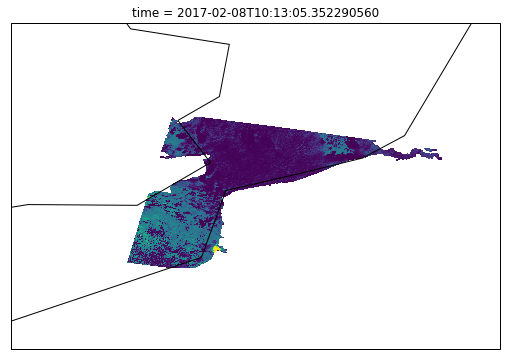

In [16]:
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds.conc_chl.isel(time=37).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([49,53])
ax.set_xlim([-1,5])

# Match-up

In [17]:
d = {'lat': np.random.uniform(low=51.3, high=52.3, size = 10), 'lon': np.random.uniform(low=2., high=3., size = 10), 'time': ['2017-01-01 10:12','2017-02-16 09:23','2017-06-18 12:34','2017-08-19 11:11','2017-11-28 08:34','2017-01-01 10:12','2017-02-16 09:23','2017-06-18 12:34','2017-08-19 11:11','2017-11-28 08:34'], 'CHL': np.random.uniform(low=0., high=32., size = 10) }

In [18]:
insitu = pd.DataFrame(d)
insitu

,CHL,lat,lon,time
0,1.171856,51.440633,2.119203,2017-01-01 10:12
1,0.413675,51.516718,2.462265,2017-02-16 09:23
2,19.135180,51.584201,2.375149,2017-06-18 12:34
3,7.769523,52.051715,2.123431,2017-08-19 11:11
4,6.657740,51.767505,2.313514,2017-11-28 08:34
5,2.771604,51.360047,2.050997,2017-01-01 10:12
6,12.284900,51.832121,2.464555,2017-02-16 09:23
7,18.957893,51.754993,2.152729,2017-06-18 12:34
8,6.092141,51.907149,2.443109,2017-08-19 11:11
9,10.945845,52.167527,2.663259,2017-11-28 08:34


In [19]:
insitu.time = pd.to_datetime(insitu.time)

In [20]:
insitu['CHL_SAT'] = ds_resampled.conc_chl.sel_points(lat = insitu.lat.values, lon = insitu.lon.values, time = insitu.time.values,method = "nearest")

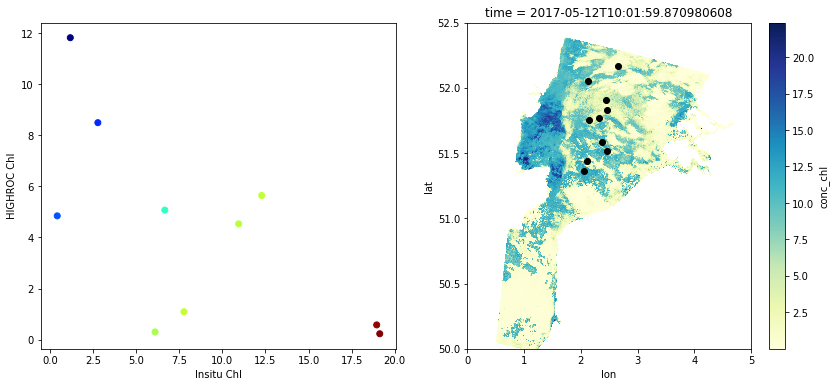

In [21]:
import matplotlib.cm as cm
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
ax.scatter(insitu.CHL,insitu.CHL_SAT, c = insitu.CHL - insitu.CHL_SAT, cmap  =cm.jet)
ax.set_xlabel("Insitu Chl")
ax.set_ylabel("HIGHROC Chl")
ax2 = fig.add_subplot(122)
ds.conc_chl.sel(time=pd.to_datetime('2017-05-12'), method='nearest').plot.imshow(ax = ax2, cmap=cm.YlGnBu)
ax2.plot(insitu.lon,insitu.lat, 'ko')

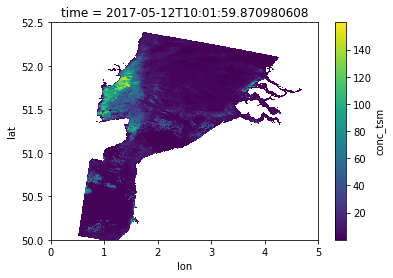

In [22]:
ds.conc_tsm.sel(time=pd.to_datetime('2017-05-12'), method='nearest').plot.imshow()

# Logical expressions

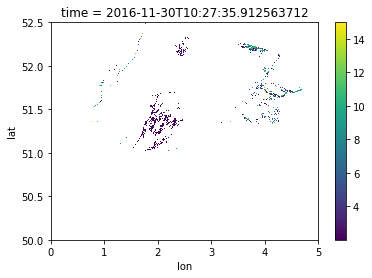

In [23]:
ds.conc_chl.where( (ds.conc_tsm < 15.) & (ds.conc_chl > 2.)).isel(time=4).plot.imshow()

# Applying custom functions

In [24]:
def DAT_corr(ds, var1 = None, var2 = None, dim ='time'):
   
    if not isinstance(ds,xr.Dataset):
        print('Input object ',ds,' is no xarray Dataset!')
        var1 = None

    if var1 is not None:  
        if var2 is None: 
            var2 = var1  
        ds_tmean = ds.mean(skipna=True, dim = dim)
        ds_tstd =  ds.std(skipna=True, dim = dim)
        covar_1 = (ds[var1] - ds_tmean[var1])*(ds[var2] - ds_tmean[var2])
        res = covar_1.mean(dim= 'time', skipna=True)/(ds_tstd[var1]*ds_tstd[var2])
    else: 
        res = None
        
    return res.persist()

In [25]:
ds_corr = DAT_corr(ds.sel(lat = slice(52.,51.5), lon = slice(3.,4.)),'conc_tsm', 'conc_chl')

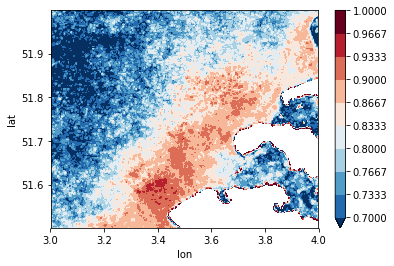

In [26]:
ds_corr.plot.contourf(levels = np.linspace(.7,1,10))